In [1]:
import matplotlib.pyplot as plt
import flowkit as fk
import os
import pandas as pd
import FlowCal
import flowsom as fs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn_extra.cluster import CLARA
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import networkx as nx
import re
from flowio import create_fcs
from scipy.stats import gmean
from fcsy import DataFrame
from fcsy import write_fcs
import matplotlib.colors as mcolors
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, adjusted_rand_score


In [2]:
# Definir los directorios de entrada y salida
work_dir = r"C:/Users/Usuario/OneDrive/Escritorio/Palex/Muestras TFM/SAMPLES_SCAFOLD"
input_dir = work_dir + '/Muestras_cluster'
output_dir = work_dir + '/clusters_clara'
flowsom_dir = work_dir + '/clusters_flowsom'
phenograph_dir = work_dir + '/clusters_phenograph'
clara_dir = work_dir + '/clusters_clara'

In [3]:
# Función para limpiar nombres de variables
def limpiar_nombre_variable(nombre):
    # Reemplazar caracteres no deseados con un guion bajo o eliminarlos (en este caso se eliminan)
    nombre_limpio = re.sub(r'[^\w]', '_', nombre)
    return nombre_limpio

Cogemos las muestras y controles normalizados con CyCombine

In [4]:
# Cogemos los labels antes de normalizar para añadirlos al final
gated_dir = work_dir + '/Controles_muestras_gated'
archivos_fcs = [f for f in os.listdir(gated_dir) if f.endswith('.fcs')]

# Lista para almacenar las columnas OmiqFilter
omiq_filter_list = []

# Procesar cada archivo FCS
for archivo in archivos_fcs:
    archivo_fcs = os.path.join(gated_dir, archivo)
    
    # Leer el archivo FCS
    fcs_data = FlowCal.io.FCSData(archivo_fcs)
    
    # Convertir el objeto FCSData a un DataFrame de pandas
    df = pd.DataFrame(fcs_data, columns=fcs_data.channels)
    
    # Almacenar la columna OmiqFilter en la lista
    omiq_filter_list.extend(df['OmiqFilter'].tolist())


Guardamos en un df solo el gating de los controles para hacer los nodos landmark y en otro guardamos todo (controles y muestras)

In [5]:
Norm_dir = work_dir + '/Controles_muestras_normalizados'
archivo_controles = 'Controles_muestras_normalizados.csv'
archivo = os.path.join(Norm_dir, archivo_controles)

df_gating_muestras_controles = pd.read_csv(archivo)

# Añadir la columna OmiqFilter a los datos de gating
df_gating_muestras_controles['OmiqFilter'] = omiq_filter_list

In [6]:
# Cambiamos los valores de la columna OmiqFilter por los nombres reales
omiq_filter_dict = {
    0: "NA",
    1: "CM CD8",
    2: "Monocitos intermedios",
    3: "Treg",
    4: "TEMRA CD8",
    5: "NK",
    6: "Monocitos clasicos",
    7: "Monocitos no clasicos",
    8: "Non Treg",
    9: "Linfocitos B",
    10: "EM CD8",
    11: "Granulocitos",
    12: "Naive CD8"
}

df_gating_muestras_controles['OmiqFilter'] = df_gating_muestras_controles['OmiqFilter'].replace(omiq_filter_dict)

In [7]:
# Asegurarse de que la columna 'sample' es de tipo cadena (string)
df_gating_muestras_controles['sample'] = df_gating_muestras_controles['sample'].astype(str)

# Filtrar las filas donde 'sample' empieza con 'C' y no es nulo
df_gating = df_gating_muestras_controles[
    df_gating_muestras_controles['sample'].str.startswith('C')
]

In [8]:
df_gating = df_gating.drop(columns=['sample', 'batch','condition','id','label'])
# Eliminamos las filas que tienen NA en la columna OmiqFilter (no queremos un nodo NA)
df_gating = df_gating[df_gating['OmiqFilter'] != 'NA']

# No dropeamos sample porque lo usamos despues para comparar distribuciones con los clusters
df_gating_muestras_controles = df_gating_muestras_controles.drop(columns=['batch','condition','id','label'])

Calculamos el MFI de cada marcador (media o mediana) para calcular la similitud de cada par de nodos

In [9]:
# Primero vamos a coger las poblaciones obtenidas por gating
medianas = pd.DataFrame()
medias = pd.DataFrame()

# Agrupar por 'OmiqFilter' y calcular medianas, medias y medias geométricas
grouped = df_gating.groupby('OmiqFilter')

for poblacion, group in grouped:
    # Obtener el nombre de la población desde la columna 'OmiqFilter'
    variable_name = limpiar_nombre_variable(poblacion)
    
    # Excluir la columna 'OmiqFilter'
    df_gating_numeric = group.drop(columns=['OmiqFilter'])
    
    # Guardar el DataFrame en una variable global
    globals()[variable_name] = df_gating_numeric
    
    # Calcular medianas, medias y medias geométricas
    medianas[variable_name] = df_gating_numeric.median()
    medias[variable_name] = df_gating_numeric.mean()

# Transponer los DataFrames de medianas, medias y medias geométricas
medias_gating = medias.T
medianas_gating = medianas.T

In [10]:
cosine_similarities = cosine_similarity(medianas_gating)
cosine_similarities = pd.DataFrame(cosine_similarities, index=medianas_gating.index, columns=medianas_gating.index)

In [11]:
# Definir el directorio donde estan los clusters
dir_clusters = flowsom_dir

In [ ]:
# Obtener la lista de archivos de control y muestras
control_files = [f for f in os.listdir(dir_clusters) if f.startswith('C') and f.endswith('.csv')]
archivos = [f for f in os.listdir(dir_clusters) if f.endswith('.csv') and not f.startswith('C')]
# Combinar las listas de controles y muestras para un procesamiento unificado
todos_los_archivos = control_files + archivos

jerarquia= {}

## Calculo del error en la asignación de poblaciones a clusters (SIN jerarquía) = Comparación Gating-Clustering
Guardamos en un dataframe (df_clustering) todas las células que hemos clusterizado asignandoles una población según la similitud del cluster (o unassigned si no llega al umbral establecido)

In [13]:
# Crear el grafo principal
G = nx.Graph()

# Crear una lista de nombres de nodos de gating
nodos_gating = medianas_gating.index.tolist()

# Añadir nodos de gating al grafo
for nodo in nodos_gating:
    num_eventos = len(globals()[limpiar_nombre_variable(nodo)])  # Calcula el número de eventos para los nodos de gating
    size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
    G.add_node(nodo, color='red', size=size)

# Crear una matriz de similitud del coseno usando medianas_gating
valores_medianos_gating = medianas_gating.values
matriz_similitud_coseno_gating = cosine_similarity(valores_medianos_gating)
np.fill_diagonal(matriz_similitud_coseno_gating, 0)
umbrales_gating = np.percentile(matriz_similitud_coseno_gating, 60, axis=0)

# Añadir aristas solo entre nodos similares basados en el umbral de similitud del coseno
for i in range(len(nodos_gating)):
    for j in range(i + 1, len(nodos_gating)):
        if matriz_similitud_coseno_gating[i, j] >= umbrales_gating[j]:
            G.add_edge(nodos_gating[i], nodos_gating[j], weight=matriz_similitud_coseno_gating[i, j]**4, color='red')

# Calcular las posiciones de los nodos de gating
pos_gating = nx.spring_layout(G, weight='weight', seed=2)

# Inicializar df_clustering vacío
df_clustering = pd.DataFrame()

# Preparar colores para los archivos
num_archivos = len(todos_los_archivos)
colores = sns.color_palette('husl', num_archivos)

leyenda = {}
tamanos_nodos = {}
nodos_cluster_todos = []

clusters_unidos_a_gating = {nodo_gating: [] for nodo_gating in nodos_gating}

# Procesar cada archivo
for idx, archivo in enumerate(todos_los_archivos):
    archivo_path = os.path.join(dir_clusters, archivo)
    df_cluster = pd.read_csv(archivo_path)

    # Eliminar columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_cluster = df_cluster.drop(columns=[col for col in columnas_a_eliminar if col in df_cluster.columns])

    # Calcular las medianas del cluster
    medianas_cluster = df_cluster.groupby('cluster').median()
    nombre_muestra = archivo.split('_clusters.csv')[0]
    medianas_cluster = medianas_cluster.rename(index=lambda x: f"C_{x}_{nombre_muestra.split('-')[0]}")
    medianas_todo = pd.concat([medianas_gating, medianas_cluster], axis=0)

    nodos_clusters = medianas_cluster.index.tolist()
    nodos_cluster_todos.extend(nodos_clusters)

    # Crear una matriz de similitud del coseno
    indices_similitud = nodos_clusters + nodos_gating
    valores_medianos = medianas_todo.loc[indices_similitud].values
    matriz_similitud_coseno = cosine_similarity(valores_medianos)
    df_similitud_coseno = pd.DataFrame(matriz_similitud_coseno, index=indices_similitud, columns=indices_similitud)

    umbrales_clusters_gating = 0.9

    # Añadir nodos de clusters al grafo
    for nodo in nodos_clusters:
        cluster_num = int(nodo.split('_')[1])
        num_eventos = len(df_cluster[df_cluster['cluster'] == cluster_num])
        tamanos_nodos[nodo] = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
        G.add_node(nodo, color=colores[idx], size=tamanos_nodos[nodo])

    # Añadir entrada a la leyenda
    leyenda[nombre_muestra.split('-')[0]] = colores[idx]

    # Añadir aristas entre clusters y nodos de gating
    for nodo_cluster in nodos_clusters:
        for nodo_gating in nodos_gating:
            if nodo_cluster in df_similitud_coseno.index and nodo_gating in df_similitud_coseno.columns:
                similitud = df_similitud_coseno.at[nodo_cluster, nodo_gating]
                if similitud >= umbrales_clusters_gating:
                    G.add_edge(nodo_cluster, nodo_gating, weight=similitud**4, color=colores[idx])
                    clusters_unidos_a_gating[nodo_gating].append(nodo_cluster)

    # Calcular posiciones de los nodos
    pos = nx.spring_layout(G, pos=pos_gating, fixed=nodos_gating, weight='weight',
                           k=0.02 / np.mean(matriz_similitud_coseno), seed=1)

    # Crear df_clustering y asignar la población
    df_cluster_mod = df_cluster.copy()

    # Obtener la similitud entre clusters y poblaciones de gating
    clusters_indices = nodos_clusters
    gating_indices = nodos_gating

    df_similitudes = df_similitud_coseno.loc[clusters_indices, gating_indices]

    # Encontrar la similitud máxima por cluster y su población correspondiente
    max_similitudes = df_similitudes.max(axis=1)
    asignaciones_clusters = df_similitudes.idxmax(axis=1)

    # Crear un diccionario de asignación cluster -> población
    dict_asignaciones = {}
    for cluster in clusters_indices:
        cluster_num = int(cluster.split('_')[1])
        if max_similitudes[cluster] >= umbrales_clusters_gating:
            dict_asignaciones[cluster_num] = asignaciones_clusters[cluster]
        else:
            dict_asignaciones[cluster_num] = 'Unassigned'

    # Añadir la columna 'Poblacion' al DataFrame
    df_cluster_mod['Poblacion'] = df_cluster_mod['cluster'].map(dict_asignaciones)

    # Añadir una columna para identificar la muestra
    df_cluster_mod['Muestra'] = nombre_muestra.split('-')[0]

    # Concatenar al DataFrame global
    df_clustering = pd.concat([df_clustering, df_cluster_mod], ignore_index=True)

# Recalcular posiciones del grafo principal si es necesario
pos_gating_general = pos

### Calculo del error

In [61]:
# Hay que limpiar los df para que sean iguales en todo
df_clustering = df_clustering.drop(columns=['cluster'])
df_gating_muestras_controles = df_gating_muestras_controles.rename(columns = {'sample' : 'Muestra'})
df_gating_muestras_controles = df_gating_muestras_controles.rename(columns = {'OmiqFilter' : 'Poblacion'})
df_gating_muestras_controles['Muestra'] = df_gating_muestras_controles['Muestra'].str.split('-').str[0]
df_gating_muestras_controles['Poblacion'] = df_gating_muestras_controles['Poblacion'].apply(limpiar_nombre_variable)
df_gating_muestras_controles['Poblacion'] = df_gating_muestras_controles['Poblacion'].replace('NA', 'Unassigned')

In [62]:
jerarquia = {'CD4': ['Treg', 'Non_Treg'], 
             'CD8': ['EM_CD8', 'TEMRA_CD8', 'CM_CD8', 'Naive_CD8'],
             'NK': ['NK'],
             'Granulocitos': ['Granulocitos'],
             'Monocitos': ['Monocitos_no_clasicos', 'Monocitos_intermedios', 'Monocitos_clasicos'],
             'Linfocitos_B': ['Linfocitos_B']
             }

# Crear un diccionario que mapee cada nodo hijo a su nodo padre
mapeo_hijo_a_padre = {}
for padre, hijos in jerarquia.items():
    for hijo in hijos:
        mapeo_hijo_a_padre[hijo] = padre

# Función para obtener el nodo padre
def obtener_padre(nodo):
    return mapeo_hijo_a_padre.get(nodo, nodo)

# Aplicar la función al DataFrame df_clustering en la columna 'Poblacion'
df_clustering['Poblacion'] = df_clustering['Poblacion'].apply(obtener_padre)

# Aplicar la función al DataFrame df_gating_muestras en la columna 'OmiqFilter'
df_gating_muestras_controles['Poblacion'] = df_gating_muestras_controles['Poblacion'].apply(obtener_padre)

Sin ocultar Unassigned

Exactitud: 0.48


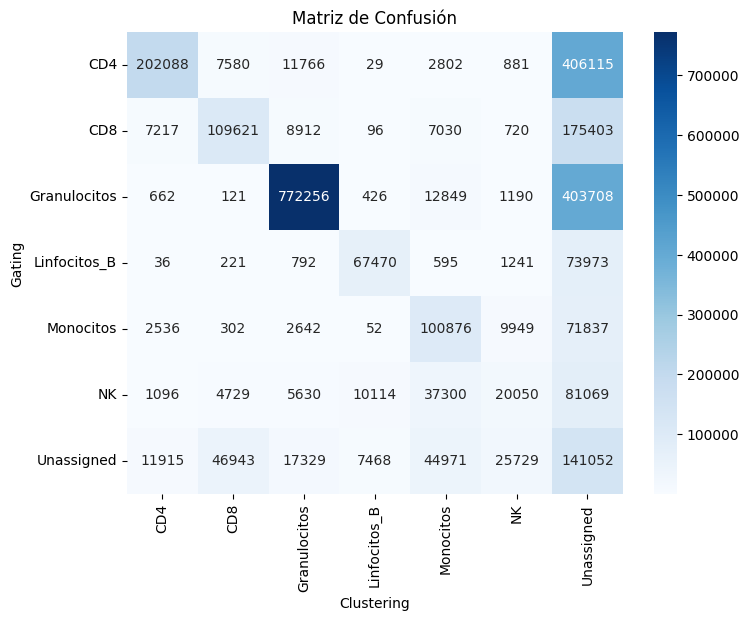

Reporte de Clasificación:
              precision    recall  f1-score   support

         CD4       0.90      0.32      0.47    631261
         CD8       0.65      0.35      0.46    308999
Granulocitos       0.94      0.65      0.77   1191212
Linfocitos_B       0.79      0.47      0.59    144328
   Monocitos       0.49      0.54      0.51    188194
          NK       0.34      0.13      0.18    159988
  Unassigned       0.10      0.48      0.17    295407

    accuracy                           0.48   2919389
   macro avg       0.60      0.42      0.45   2919389
weighted avg       0.75      0.48      0.55   2919389

Coeficiente Kappa de Cohen: 0.36
Índice de Rand Ajustado: 0.25


In [63]:
# Extraer las asignaciones de población
y_clustering = df_clustering['Poblacion']
y_gating = df_gating_muestras_controles['Poblacion']

# Calcular la exactitud
accuracy = accuracy_score(y_gating, y_clustering)
print(f'Exactitud: {accuracy:.2f}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_gating, y_clustering)

# Mostrar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df_gating_muestras_controles['Poblacion'].unique()),
            yticklabels=sorted(df_gating_muestras_controles['Poblacion'].unique()))
plt.xlabel('Clustering')
plt.ylabel('Gating')
plt.title('Matriz de Confusión')
plt.show()


report = classification_report(y_gating, y_clustering)
print('Reporte de Clasificación:')
print(report)


kappa = cohen_kappa_score(y_gating, y_clustering)
print(f'Coeficiente Kappa de Cohen: {kappa:.2f}')



ari = adjusted_rand_score(y_gating, y_clustering)
print(f'Índice de Rand Ajustado: {ari:.2f}')

Eliminamos los Unassigned

In [64]:
mask = (y_clustering != 'Unassigned') & (y_gating != 'Unassigned')
y_clustering_filtered = y_clustering[mask]
y_gating_filtered = y_gating[mask]

Exactitud: 0.90
Coeficiente Kappa de Cohen: 0.84
Índice de Rand Ajustado: 0.87

Reporte de Clasificación:
              precision    recall  f1-score   support

         CD4       0.95      0.90      0.92    225146
         CD8       0.89      0.82      0.86    133596
Granulocitos       0.96      0.98      0.97    787504
Linfocitos_B       0.86      0.96      0.91     70355
   Monocitos       0.62      0.87      0.73    116357
          NK       0.59      0.25      0.36     78919

    accuracy                           0.90   1411877
   macro avg       0.81      0.80      0.79   1411877
weighted avg       0.90      0.90      0.89   1411877



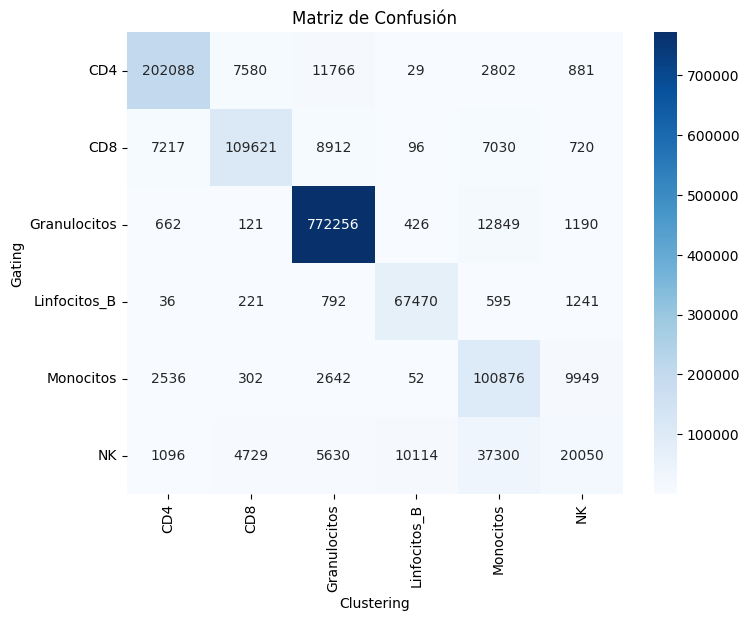

In [65]:
# Paso 1: Filtrar células asignadas
mask = (df_clustering['Poblacion'] != 'Unassigned') & (df_gating_muestras_controles['Poblacion'] != 'Unassigned')
y_clustering = df_clustering.loc[mask, 'Poblacion']
y_gating = df_gating_muestras_controles.loc[mask, 'Poblacion']

# Paso 2: Calcular métricas
accuracy = accuracy_score(y_gating, y_clustering)
conf_matrix = confusion_matrix(y_gating, y_clustering)
report = classification_report(y_gating, y_clustering)
kappa = cohen_kappa_score(y_gating, y_clustering)
ari = adjusted_rand_score(y_gating, y_clustering)

# Paso 3: Mostrar resultados
print(f'Exactitud: {accuracy:.2f}')
print(f'Coeficiente Kappa de Cohen: {kappa:.2f}')
print(f'Índice de Rand Ajustado: {ari:.2f}')
print('\nReporte de Clasificación:')
print(report)

# Paso 4: Visualizar matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_gating.unique()),
            yticklabels=sorted(y_gating.unique()))
plt.xlabel('Clustering')
plt.ylabel('Gating')
plt.title('Matriz de Confusión')
plt.show()

### Otras comparaciones cluster-gating

In [16]:
archivos_muestras = archivos
# Variables para almacenar los porcentajes y asignaciones
cluster_assignments = {}
porcentajes_poblaciones = {}

# Procesar los controles individualmente
for control_file in control_files:
    archivo_path = os.path.join(dir_clusters, control_file)
    df_control = pd.read_csv(archivo_path)
    
    # Eliminar las columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_control = df_control.drop(columns=[col for col in columnas_a_eliminar if col in df_control.columns])
    
    # Renombrar los clusters para identificar el control
    medianas_cluster_control = df_control.groupby('cluster').median()
    medianas_cluster_control = medianas_cluster_control.rename(index=lambda x: f"C_{x}_{control_file}")
    medianas_todo_control = pd.concat([medianas_gating, medianas_cluster_control], axis=0)
    
    nodos_clusters_control = medianas_cluster_control.index.tolist()
    nodos = nodos_gating + nodos_clusters_control
    
    nodos_hijos = [nodo for subnodos in jerarquia.values() for nodo in subnodos]
    nodos_padre = list(jerarquia.keys())
    medianas_sin_padre_control = medianas_todo_control.drop(nodos_padre, errors='ignore')
    
    # Crear matriz de similitud para este control
    valores_medianos_control = np.vstack([medianas_sin_padre_control.loc[nodo].values for nodo in medianas_sin_padre_control.index])
    matriz_similitud_coseno_control = cosine_similarity(valores_medianos_control)
    df_similitud_coseno_control = pd.DataFrame(
        matriz_similitud_coseno_control,
        index=medianas_sin_padre_control.index,
        columns=medianas_sin_padre_control.index
    )
    
    umbral_clusters_gating = 0.9
    
    # Inicializar diccionarios para este control
    cluster_assignments_control = {}
    node_clusters_control = {nodo: [] for nodo in nodos_gating + nodos_padre + nodos_hijos}
    
    # Asignar clusters de control a nodos de gating, padres o hijos
    for nodo_cluster in nodos_clusters_control:
        max_similitud = 0
        nodo_asignado = None
        for nodo_ref in nodos_gating + nodos_hijos:
            if nodo_ref in medianas_sin_padre_control.index:
                similitud = df_similitud_coseno_control.loc[nodo_cluster, nodo_ref]
                if similitud >= umbral_clusters_gating and similitud > max_similitud:
                    max_similitud = similitud
                    nodo_asignado = nodo_ref
    
        if nodo_asignado:
            cluster_assignments_control[nodo_cluster] = nodo_asignado
            node_clusters_control[nodo_asignado].append(nodo_cluster)
        else:
            cluster_assignments_control[nodo_cluster] = None
    
    # Calcular porcentajes para este control individual
    total_celulas_control = len(df_control)
    porcentajes_poblaciones[control_file] = {}
    
    for nodo in nodos_gating + nodos_padre + nodos_hijos:
        clusters_asignados = node_clusters_control.get(nodo, [])
        if clusters_asignados:
            cluster_nums = [int(c.split('_')[1]) for c in clusters_asignados]
            celulas_asociadas = df_control[df_control['cluster'].isin(cluster_nums)].shape[0]
            porcentaje = (celulas_asociadas / total_celulas_control) * 100
            porcentajes_poblaciones[control_file][nodo] = porcentaje
    
    # Calcular porcentaje de clusters no asignados
    clusters_asignados = set([cluster for cluster, nodo in cluster_assignments_control.items() if nodo is not None])
    clusters_no_asignados = set(nodos_clusters_control) - clusters_asignados
    if clusters_no_asignados:
        cluster_nums_no_asignados = [int(c.split('_')[1]) for c in clusters_no_asignados]
        celulas_no_conectadas = df_control[df_control['cluster'].isin(cluster_nums_no_asignados)].shape[0]
        porcentaje_no_conectados = (celulas_no_conectadas / total_celulas_control) * 100
        porcentajes_poblaciones[control_file]['Unassigned'] = porcentaje_no_conectados
    else:
        porcentajes_poblaciones[control_file]['Unassigned'] = 0

# Procesar muestras individuales
for archivo in archivos_muestras:
    archivo_path = os.path.join(dir_clusters, archivo)
    df_cluster = pd.read_csv(archivo_path)
    
    # Eliminar las columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_cluster = df_cluster.drop(columns=[col for col in columnas_a_eliminar if col in df_cluster.columns])
    
    # Renombrar los clusters para identificar el archivo
    medianas_cluster = df_cluster.groupby('cluster').median()
    medianas_cluster = medianas_cluster.rename(index=lambda x: f"C_{x}_{archivo}")
    medianas_todo = pd.concat([medianas_gating, medianas_cluster], axis=0)
    
    nodos_clusters = medianas_cluster.index.tolist()
    nodos = nodos_gating + nodos_clusters
    
    medianas_sin_padre = medianas_todo.drop(nodos_padre, errors='ignore')
    
    # Crear una matriz de similitud del coseno
    valores_medianos = np.vstack([medianas_sin_padre.loc[nodo].values for nodo in medianas_sin_padre.index])
    matriz_similitud_coseno = cosine_similarity(valores_medianos)
    df_similitud_coseno = pd.DataFrame(
        matriz_similitud_coseno,
        index=medianas_sin_padre.index,
        columns=medianas_sin_padre.index
    )
    
    umbral_clusters_gating = 0.9
    
    # Inicializar diccionarios para esta muestra
    cluster_assignments_muestra = {}
    node_clusters_muestra = {nodo: [] for nodo in nodos_gating + nodos_padre + nodos_hijos}
    
    # Asignar clusters a nodos de gating, padres o hijos
    for nodo_cluster in nodos_clusters:
        max_similitud = 0
        nodo_asignado = None
        for nodo_ref in nodos_gating + nodos_hijos:
            if nodo_ref in medianas_sin_padre.index:
                similitud = df_similitud_coseno.loc[nodo_cluster, nodo_ref]
                if similitud >= umbral_clusters_gating and similitud > max_similitud:
                    max_similitud = similitud
                    nodo_asignado = nodo_ref
    
        if nodo_asignado:
            cluster_assignments_muestra[nodo_cluster] = nodo_asignado
            node_clusters_muestra[nodo_asignado].append(nodo_cluster)
        else:
            cluster_assignments_muestra[nodo_cluster] = None
    
    # Calcular porcentajes
    total_celulas = len(df_cluster)
    porcentajes_poblaciones[archivo] = {}
    
    for nodo in nodos_gating + nodos_padre + nodos_hijos:
        clusters_asignados = node_clusters_muestra.get(nodo, [])
        if clusters_asignados:
            cluster_nums = [int(c.split('_')[1]) for c in clusters_asignados]
            celulas_asociadas = df_cluster[df_cluster['cluster'].isin(cluster_nums)].shape[0]
            porcentaje = (celulas_asociadas / total_celulas) * 100
            porcentajes_poblaciones[archivo][nodo] = porcentaje
    
    # Calcular porcentaje de clusters no asignados
    clusters_asignados = set([cluster for cluster, nodo in cluster_assignments_muestra.items() if nodo is not None])
    clusters_no_asignados = set(nodos_clusters) - clusters_asignados
    if clusters_no_asignados:
        cluster_nums_no_asignados = [int(c.split('_')[1]) for c in clusters_no_asignados]
        celulas_no_conectadas = df_cluster[df_cluster['cluster'].isin(cluster_nums_no_asignados)].shape[0]
        porcentaje_no_conectados = (celulas_no_conectadas / total_celulas) * 100
        porcentajes_poblaciones[archivo]['Unassigned'] = porcentaje_no_conectados
    else:
        porcentajes_poblaciones[archivo]['Unassigned'] = 0

# Crear el DataFrame de porcentajes
df_porcentajes = pd.DataFrame(porcentajes_poblaciones).T.fillna(0)

# Reordenar las columnas para que 'Unassigned' sea la última
if 'Unassigned' in df_porcentajes.columns:
    cols = [col for col in df_porcentajes.columns if col != 'Unassigned'] + ['Unassigned']
    df_porcentajes = df_porcentajes[cols]

In [17]:
# Definir la jerarquía de nodos
jerarquia = {
    'Linfocitos': ['Linfocitos_B', 'Treg', 'Non_Treg', 'Naive_CD8', 'EM_CD8', 'CM_CD8', 'TEMRA_CD8', 'NK'],
    'Monocitos': ['Monocitos_no_clasicos', 'Monocitos_intermedios', 'Monocitos_clasicos']
}


# Aplicar la jerarquía al DataFrame de porcentajes para df_nuevo
nodos_hijos = [hijo for hijos in jerarquia.values() for hijo in hijos]
nodos_padre = list(jerarquia.keys())
nodos_no_jerarquia = [col for col in df_porcentajes.columns if col not in nodos_hijos and col not in nodos_padre]

df_nuevo = pd.DataFrame(index=df_porcentajes.index)

# Calcular los porcentajes de los nodos padre sumando los porcentajes de sus hijos
for padre, hijos in jerarquia.items():
    hijos_presentes = [hijo for hijo in hijos if hijo in df_porcentajes.columns]
    if hijos_presentes:
        df_nuevo[padre] = df_porcentajes[hijos_presentes].sum(axis=1)

# Añadir las columnas de los nodos que no están en la jerarquía
df_nuevo = pd.concat([df_nuevo, df_porcentajes[nodos_no_jerarquia]], axis=1)

# Asegurar que 'Unassigned' sea la última columna
if 'Unassigned' in df_nuevo.columns:
    cols = [col for col in df_nuevo.columns if col != 'Unassigned'] + ['Unassigned']
    df_nuevo = df_nuevo[cols]

# Crear un nuevo DataFrame para controles individuales
df_controles_individuales = df_nuevo[df_nuevo.index.str.startswith('C')]
df_muestras = df_nuevo[~df_nuevo.index.str.startswith('C')]

# Verificar las sumas de porcentajes por muestra
df_nuevo['Suma'] = df_nuevo.sum(axis=1)


# Asegurarse de que los índices son de tipo cadena (string)
df_nuevo.index = df_nuevo.index.astype(str)

# Eliminar todo lo que va después del primer guion bajo en los nombres de los índices
df_nuevo.index = df_nuevo.index.str.split('_').str[0]

In [18]:
# 1. Contar las ocurrencias por muestra y población
conteos = df_gating_muestras_controles.groupby(['sample', 'OmiqFilter']).size().reset_index(name='counts')

# 2. Calcular el total de células por muestra
totales = df_gating_muestras_controles.groupby('sample').size().reset_index(name='total_cells')

# 3. Unir los conteos con los totales para calcular los porcentajes
conteos = conteos.merge(totales, on='sample')
conteos['percentage'] = (conteos['counts'] / conteos['total_cells']) * 100

# 4. Crear un DataFrame pivotado con los porcentajes
df_porcentajes_gating = conteos.pivot(index='sample', columns='OmiqFilter', values='percentage').fillna(0)

# Cambiamos el nombre de NA a Unassigned y lo dejamos al final
df_porcentajes_gating = df_porcentajes_gating.rename(columns = {'NA': 'Unassigned'})

# Reordenar las columnas para que 'Unassigned' sea la última
if 'Unassigned' in df_porcentajes_gating.columns:
    cols = [col for col in df_porcentajes_gating.columns if col != 'Unassigned'] + ['Unassigned']
    df_porcentajes_gating = df_porcentajes_gating[cols]

In [19]:
# Definir la jerarquía de nodos
jerarquia = {
    'Linfocitos': ['Linfocitos B', 'Treg', 'Non Treg', 'Naive CD8', 'EM CD8', 'CM CD8', 'TEMRA CD8', 'NK'],
    'Monocitos': ['Monocitos no clasicos', 'Monocitos intermedios', 'Monocitos clasicos']
}


# Aplicar la jerarquía al DataFrame de porcentajes para df_nuevo
nodos_hijos = [hijo for hijos in jerarquia.values() for hijo in hijos]
nodos_padre = list(jerarquia.keys())
nodos_no_jerarquia = [col for col in df_porcentajes_gating.columns if col not in nodos_hijos and col not in nodos_padre]

df_nuevo_gating = pd.DataFrame(index=df_porcentajes_gating.index)

# Calcular los porcentajes de los nodos padre sumando los porcentajes de sus hijos
for padre, hijos in jerarquia.items():
    hijos_presentes = [hijo for hijo in hijos if hijo in df_porcentajes_gating.columns]
    if hijos_presentes:
        df_nuevo_gating[padre] = df_porcentajes_gating[hijos_presentes].sum(axis=1)

# Añadir las columnas de los nodos que no están en la jerarquía
df_nuevo_gating = pd.concat([df_nuevo_gating, df_porcentajes_gating[nodos_no_jerarquia]], axis=1)

# Asegurar que 'Unassigned' sea la última columna
if 'Unassigned' in df_nuevo_gating.columns:
    cols = [col for col in df_nuevo_gating.columns if col != 'Unassigned'] + ['Unassigned']
    df_nuevo_gating = df_nuevo_gating[cols]

# Crear un nuevo DataFrame para controles individuales
df_controles_individuales_gating = df_nuevo_gating[df_nuevo_gating.index.str.startswith('C')]
df_muestras_gating = df_nuevo_gating[~df_nuevo_gating.index.str.startswith('C')]

# Verificar las sumas de porcentajes por muestra
df_nuevo_gating['Suma'] = df_nuevo_gating.sum(axis=1)

In [57]:
# Seleccionar solo las columnas numéricas de interés
columnas_interes = ['Linfocitos', 'Monocitos', 'Granulocitos']

# Filtrar las columnas de interés y eliminar 'Unassigned'
df_nuevo_assigned = df_nuevo[columnas_interes]
df_nuevo_gating_assigned = df_nuevo_gating[columnas_interes]

# Recalcular los porcentajes para que la suma de las columnas restantes sea el 100%
df_nuevo_assigned = df_nuevo_assigned.div(df_nuevo_assigned.sum(axis=1), axis=0) * 100
df_nuevo_gating_assigned = df_nuevo_gating_assigned.div(df_nuevo_gating_assigned.sum(axis=1), axis=0) * 100

# Recuperar la columna 'sample' y añadirla a los nuevos DataFrames
df_nuevo_assigned['Sample'] = df_nuevo.index
#df_nuevo_gating_assigned['Sample'] = df_nuevo_gating.index

# Asegurar que los índices sean compatibles y convertirlos en columna si es necesario
df_nuevo_gating_assigned = df_nuevo_gating_assigned.reset_index().rename(columns={'sample': 'Sample'})

# Añadir una columna que identifique el origen de los datos
df_nuevo_gating_assigned['Método'] = 'Gating'
df_nuevo_assigned['Método'] = 'Clustering'

In [58]:
# Restablecer el índice de df_nuevo_gating_assigned
df_nuevo_gating_assigned.reset_index(drop=True, inplace=True)

# Restablecer el índice de df_nuevo_assigned
df_nuevo_assigned.reset_index(drop=True, inplace=True)

# Ahora concatenar los DataFrames
df_combinado = pd.concat([df_nuevo_gating_assigned, df_nuevo_assigned], ignore_index=True)

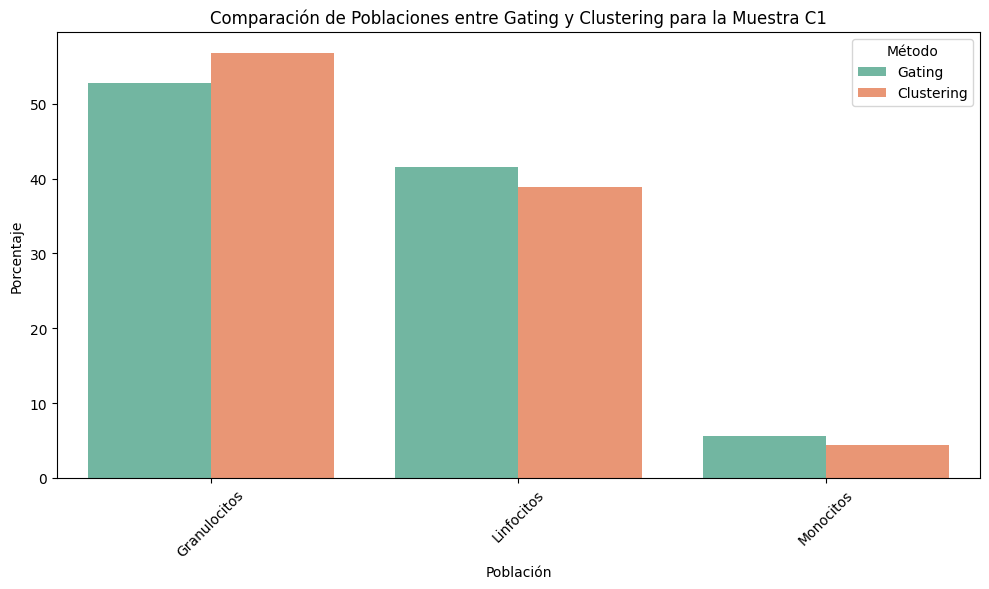

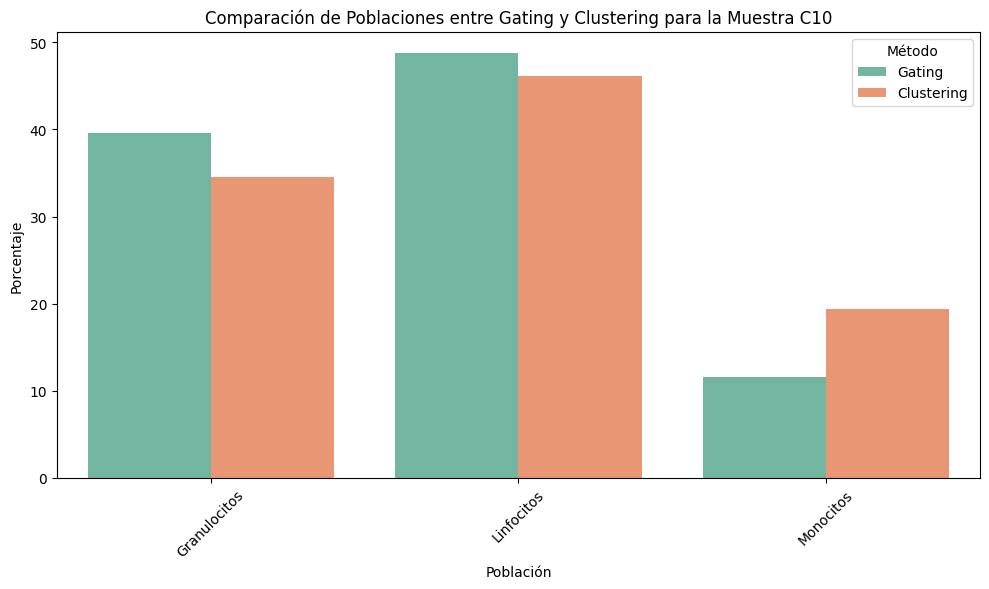

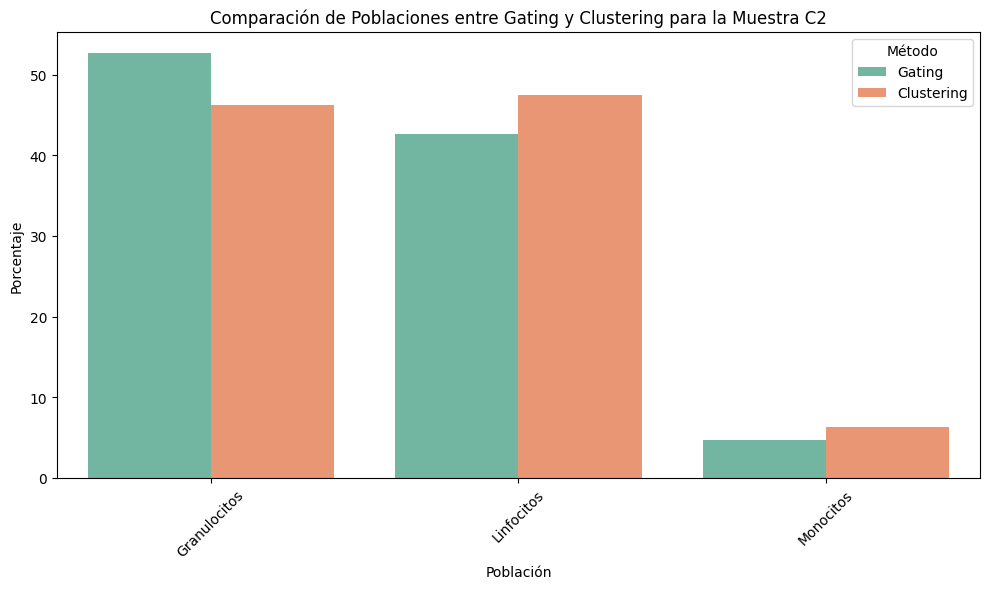

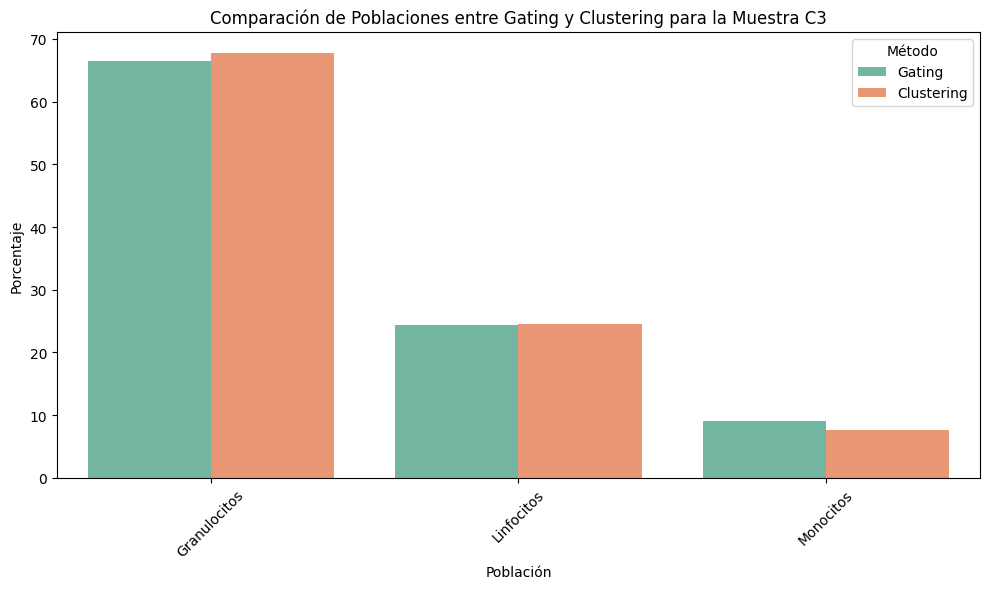

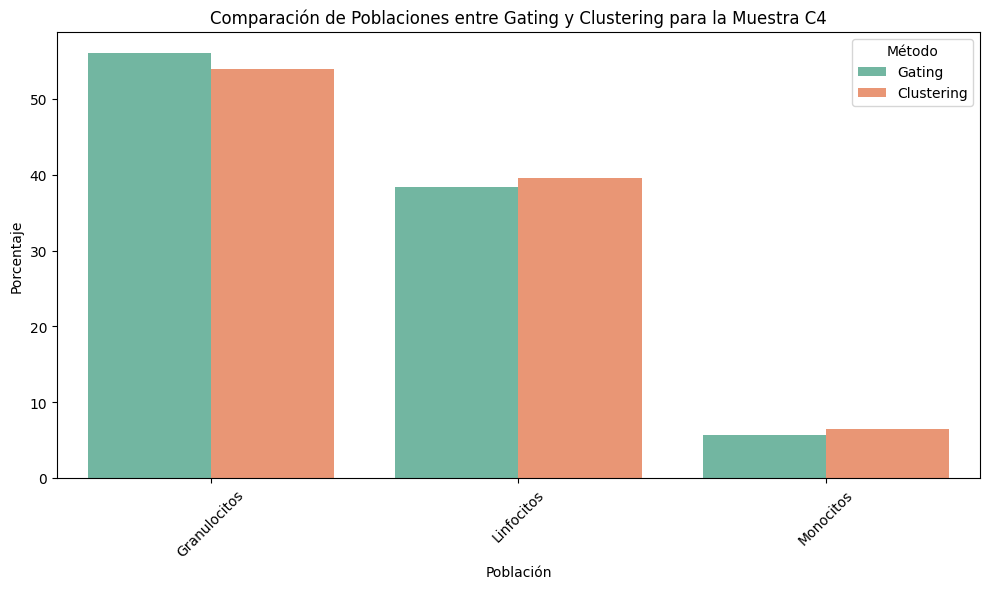

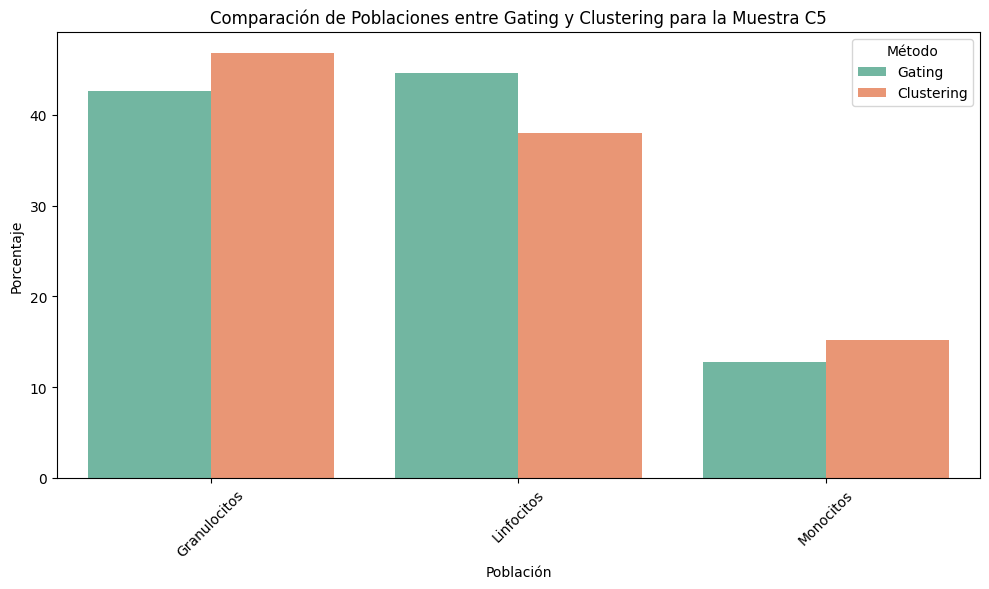

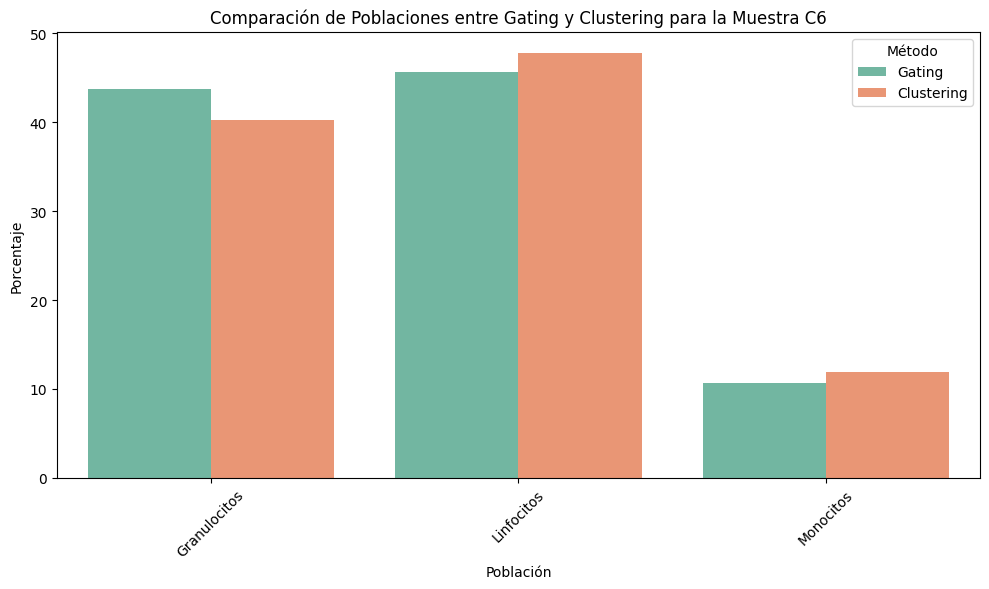

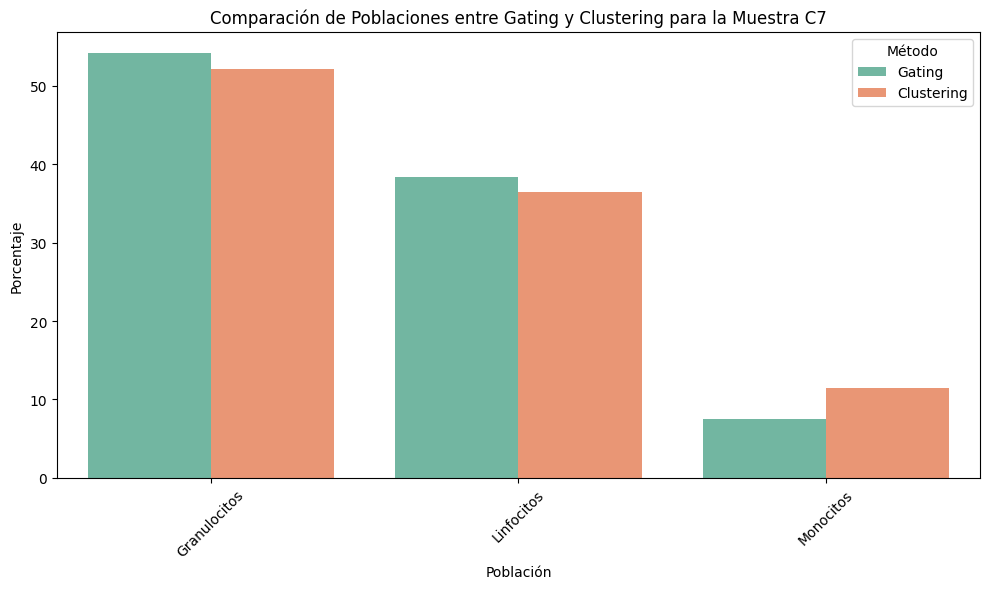

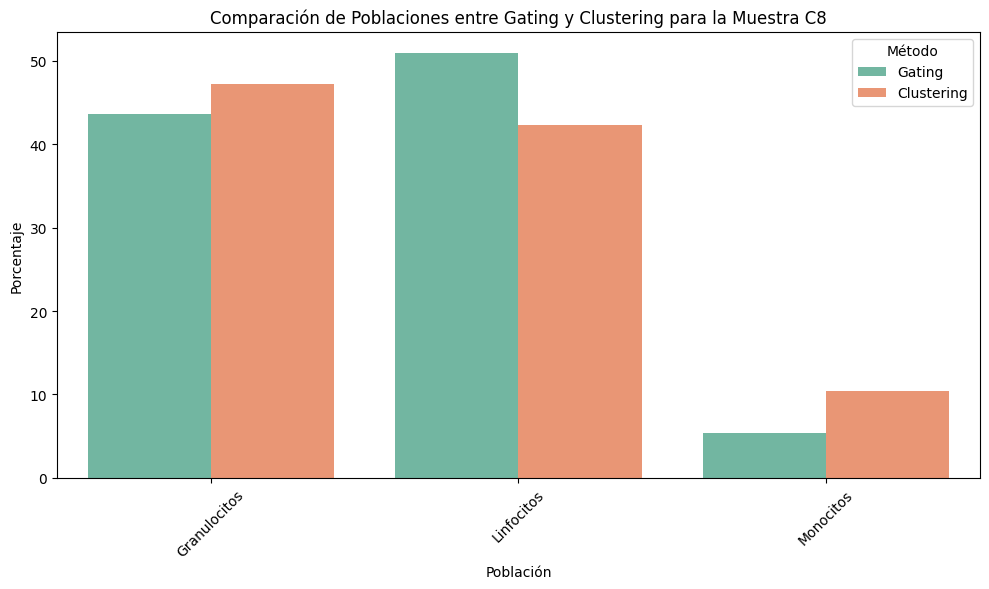

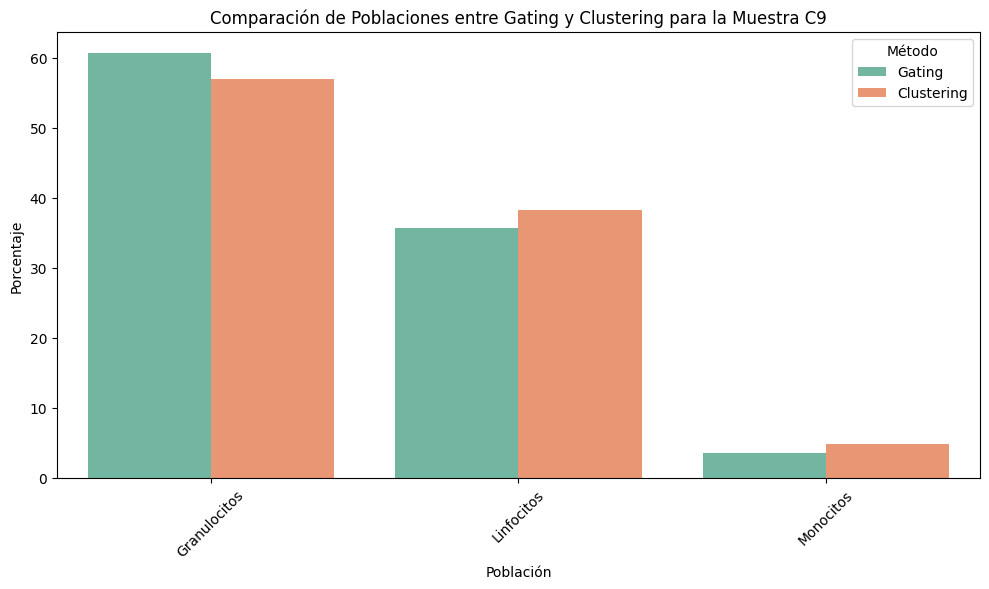

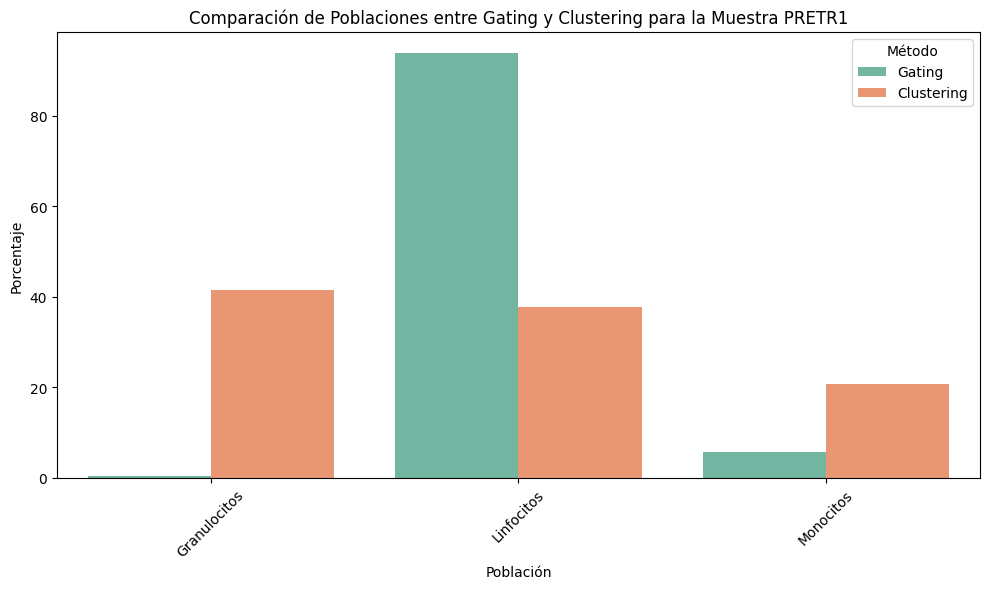

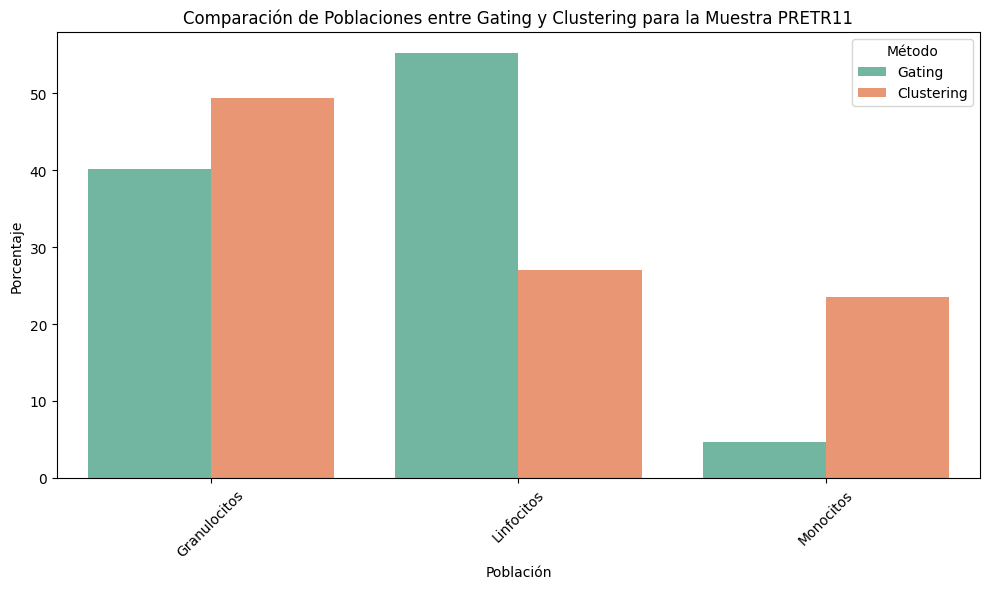

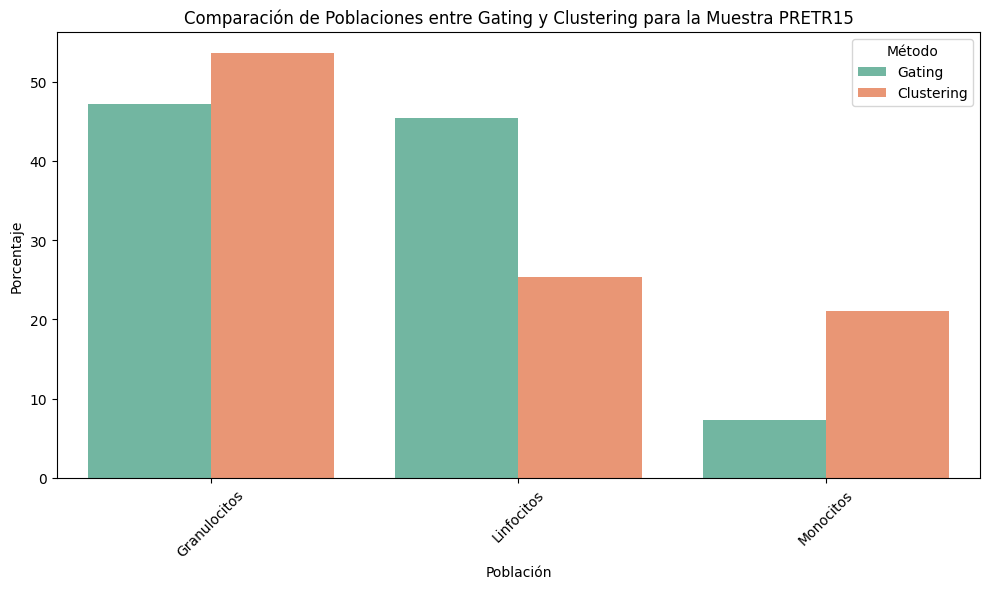

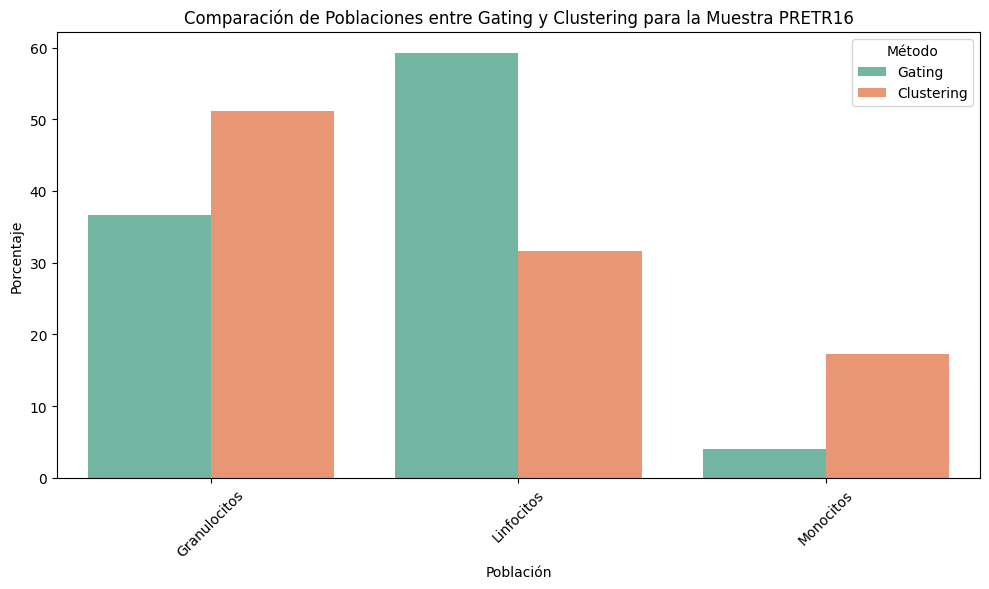

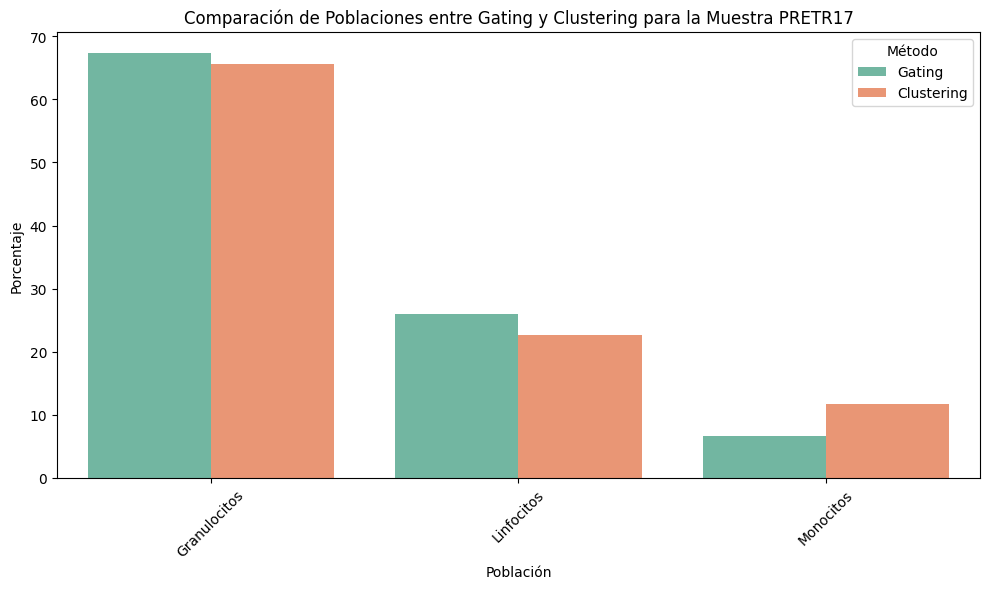

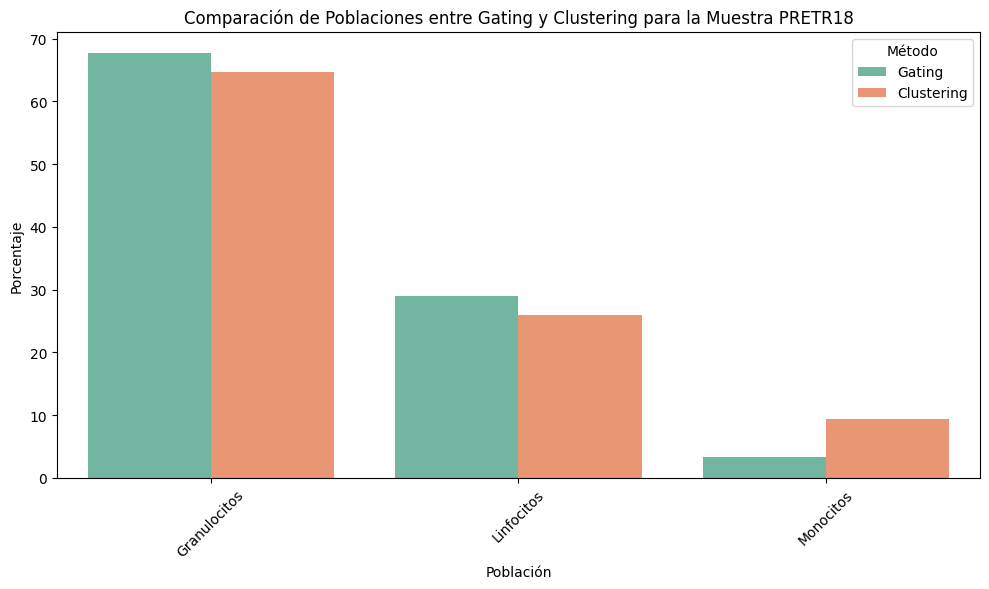

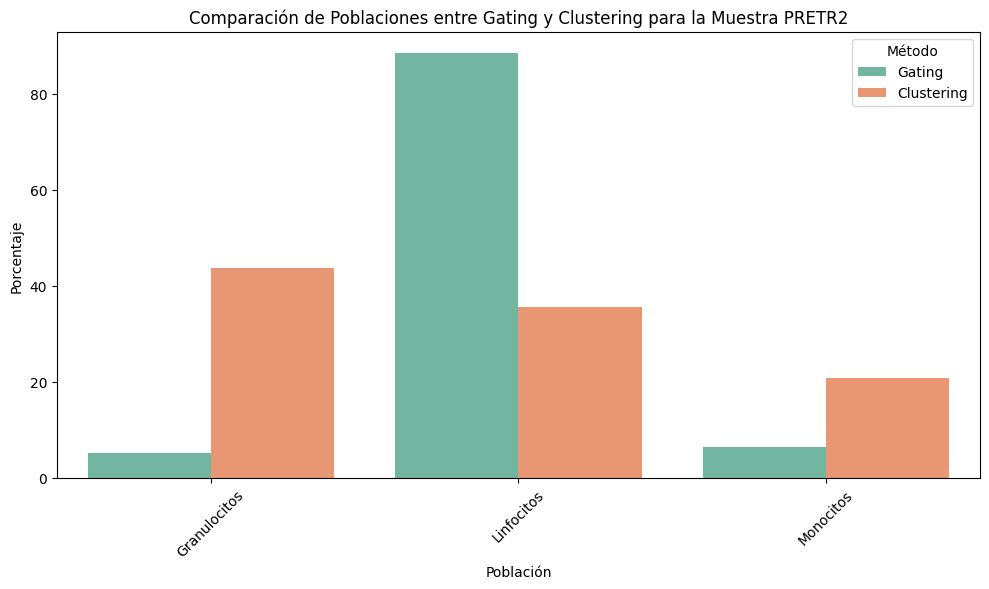

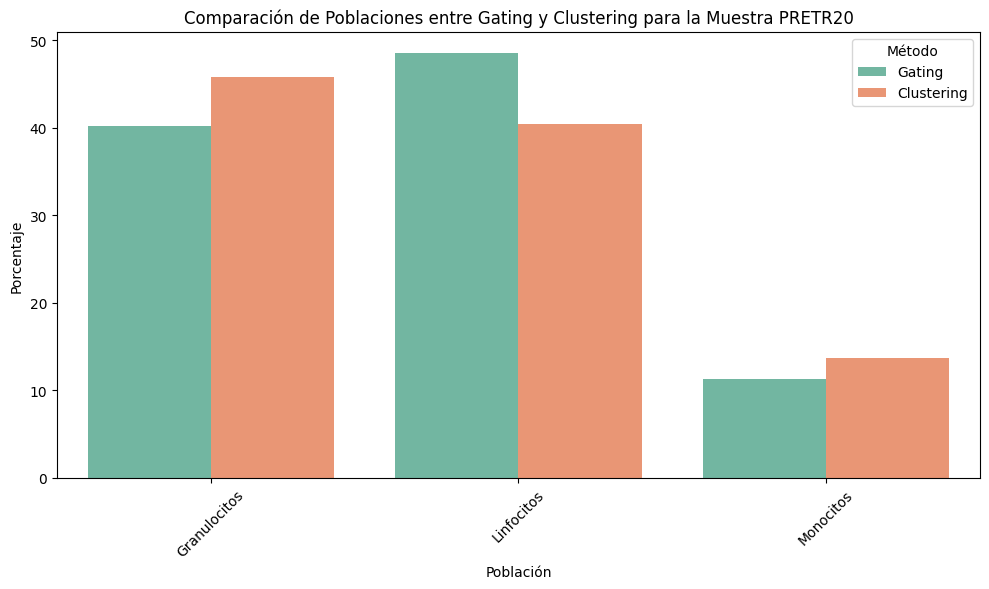

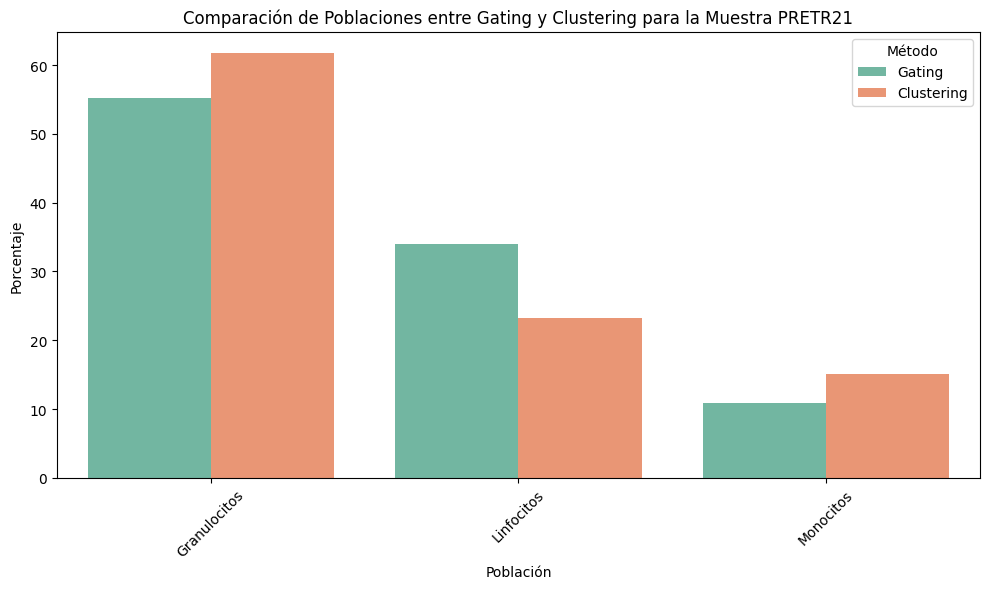

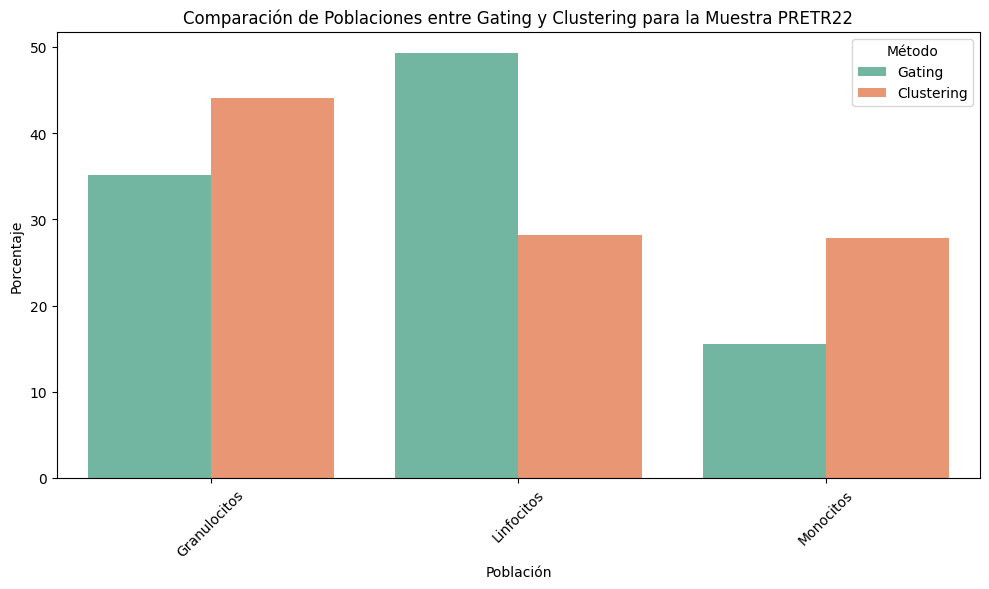

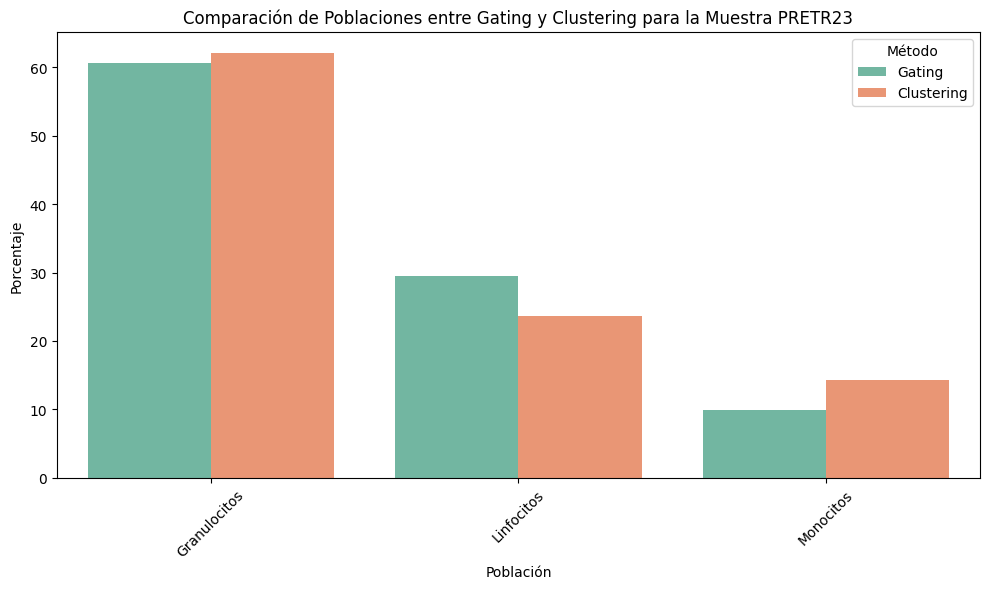

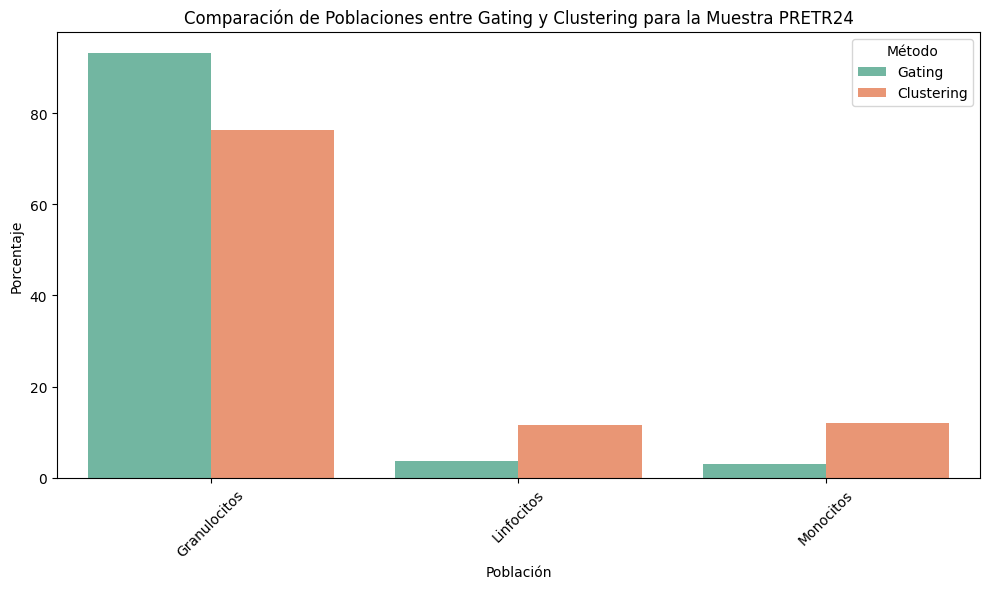

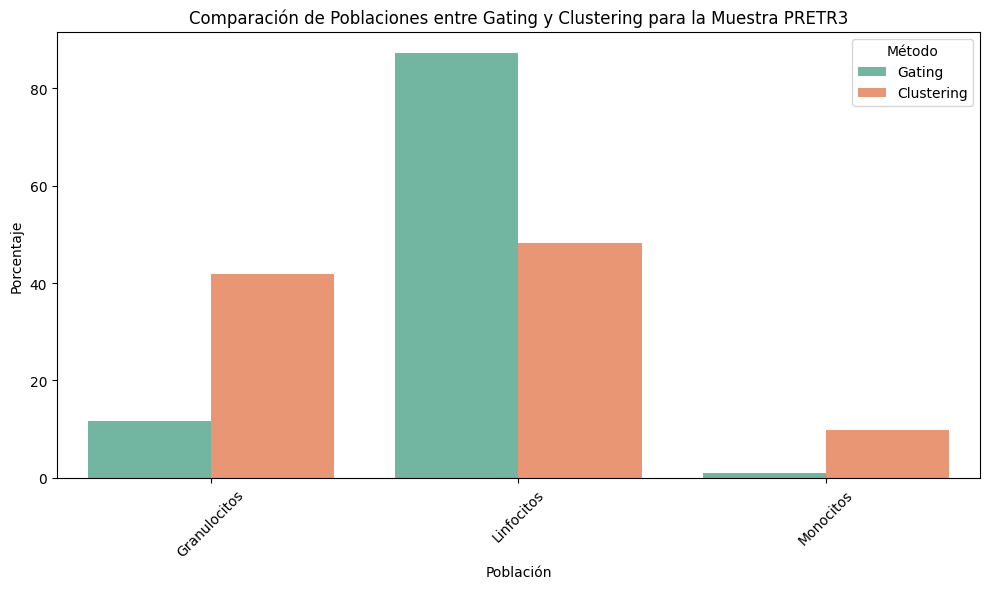

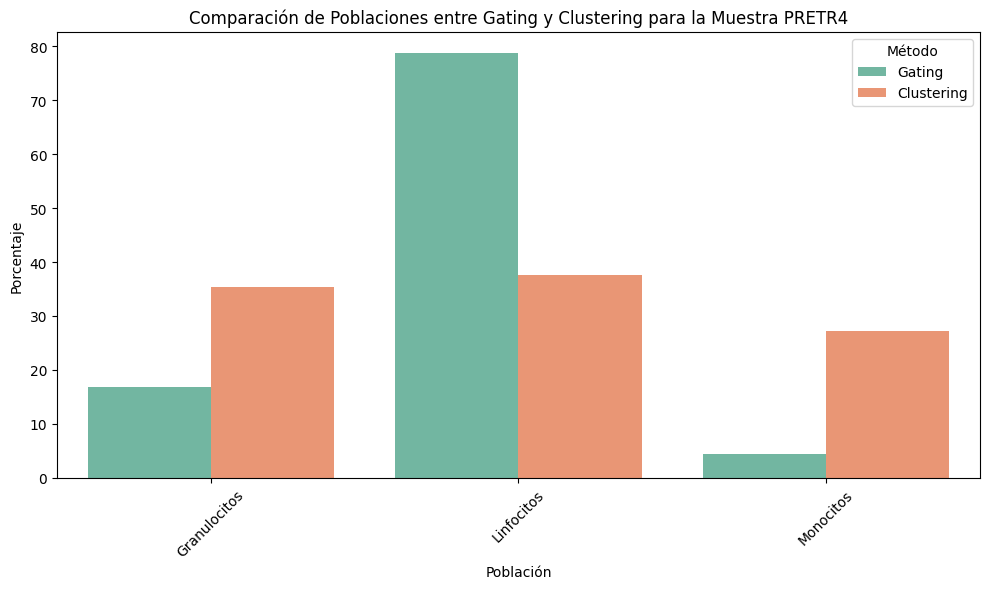

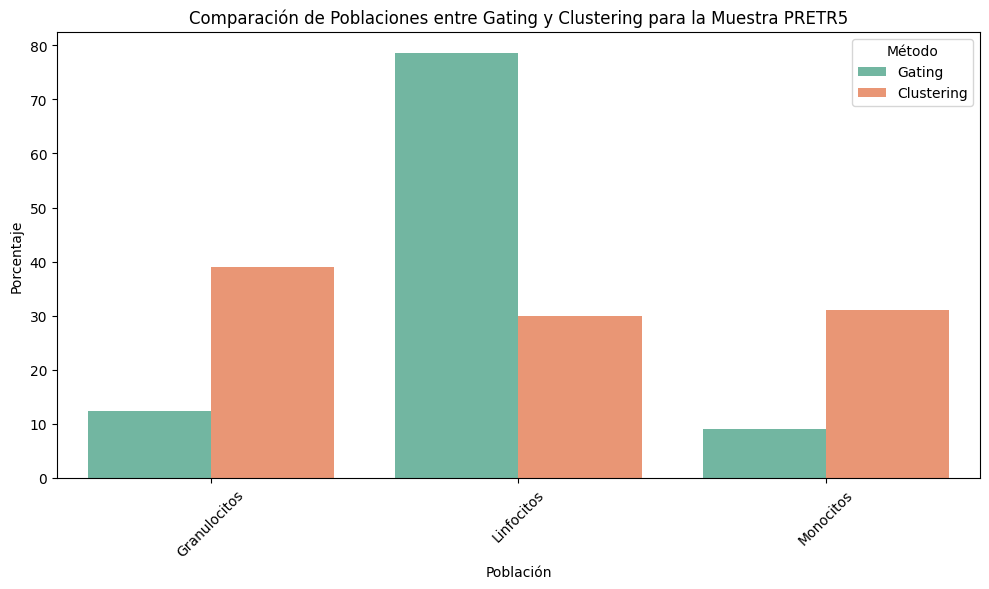

In [52]:
# Unir los DataFrames
df_combinado = pd.concat([df_nuevo_gating_assigned, df_nuevo_assigned], ignore_index=True)

# Seleccionar las columnas de poblaciones (excluyendo columnas adicionales)
columnas_poblaciones = [col for col in df_nuevo_gating_assigned.columns if col not in ['Sample', 'Suma', 'Método', 'index']]

# Transformar el DataFrame a formato largo
df_melt = df_combinado.melt(
    id_vars=['Sample', 'Método'],
    value_vars=columnas_poblaciones,
    var_name='Población',
    value_name='Porcentaje'
)

# Filtrar las muestras que deseas comparar (si es necesario)
# En este caso, asumimos que todas las muestras deben ser incluidas y que los nombres son iguales en ambos DataFrames

# Ordenar las muestras y poblaciones para consistencia
df_melt.sort_values(by=['Sample', 'Población'], inplace=True)

# Lista de muestras únicas
muestras_unicas = df_melt['Sample'].unique()

# Crear un gráfico para cada muestra
for muestra in muestras_unicas:
    # Filtrar datos de la muestra actual
    df_muestra = df_melt[df_melt['Sample'] == muestra]
    
    plt.figure(figsize=(10, 6))
    
    # Graficar las poblaciones comparando ambos métodos
    sns.barplot(
        data=df_muestra,
        x='Población',
        y='Porcentaje',
        hue='Método',
        palette='Set2'
    )
    
    plt.title(f'Comparación de Poblaciones entre Gating y Clustering para la Muestra {muestra.split("-")[0]}')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Método')
    plt.show()